<a href="https://colab.research.google.com/github/mdiazmat/DSBA6165Project/blob/main/SCIN_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
from google.cloud import storage
auth.authenticate_user()

In [2]:
# This is to double check the bucket contents
!gsutil ls gs://dx-scin-public-data/dataset/

gs://dx-scin-public-data/dataset/scin_app_questions.csv
gs://dx-scin-public-data/dataset/scin_cases.csv
gs://dx-scin-public-data/dataset/scin_label_questions.csv
gs://dx-scin-public-data/dataset/scin_labels.csv
gs://dx-scin-public-data/dataset/images/


In [3]:
import io
import pandas as pd

client = storage.Client(project="dx-scin-public")
bucket = client.bucket("dx-scin-public-data")

def load_csv_from_bucket(filename):
    blob = bucket.blob(f"dataset/{filename}")
    data = blob.download_as_bytes()
    return pd.read_csv(io.BytesIO(data))


In [4]:
cases_df = load_csv_from_bucket("scin_cases.csv")
labels_df = load_csv_from_bucket("scin_labels.csv")
print("Cases shape:", cases_df.shape)
print("Labels shape:", labels_df.shape)

Cases shape: (5033, 57)
Labels shape: (5033, 17)


In [5]:
# Merge on case_id to attach dermatologist labels to each case record.
scin_df = pd.merge(cases_df, labels_df, on="case_id", how="inner")
print("Merged shape:", scin_df.shape)

Merged shape: (5033, 73)


In [6]:
# These features are the most similar to the derm_transcripts so when we combine them it'll be easier
columns_keep = [
    "case_id",
    "image_1_path",
    "sex_at_birth",
    "fitzpatrick_skin_type",
    "weighted_skin_condition_label", # ex "{'acne': 1.0}"
    "dermatologist_skin_condition_on_label_name"
]
scin_small = scin_df[columns_keep]

In [7]:
scin_small.head(3)

,case_id,image_1_path,sex_at_birth,fitzpatrick_skin_type,weighted_skin_condition_label,dermatologist_skin_condition_on_label_name
0,-1000600354148496558,dataset/images/-3205742176803893704.png,OTHER_OR_UNSPECIFIED,NaN,"{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...","['Inflicted skin lesions', 'Eczema', 'Irritant..."
1,-1002039107727665188,dataset/images/-4762289084741430925.png,OTHER_OR_UNSPECIFIED,NaN,"{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...","['Prurigo nodularis', 'Actinic Keratosis', 'SC..."
2,-1003358831658393077,dataset/images/-4027806997035329030.png,MALE,NONE_IDENTIFIED,"{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...","['Impetigo', 'Herpes Zoster', 'Bullous dermati..."


In [8]:
import ast

def extract_condition(x):
  """Convert the SCIN `weighted_skin_condition_label` string into a simple label.
  Ex: "{'acne': 1.0}" -> "acne"
  If parsing fails, returns None.
  """
  try:
      d = ast.literal_eval(x)
      if isinstance(d, dict):
          return list(d.keys())[0]
  except Exception:
      return None

In [9]:
scin_small["condition_clean"] = scin_small["weighted_skin_condition_label"].apply(extract_condition)
# normalize for consistent matching
scin_small["condition_clean"] = (
    scin_small["condition_clean"].astype(str).str.lower().str.replace(" ", "_")
    )

/tmp/ipython-input-950010110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scin_small["condition_clean"] = scin_small["weighted_skin_condition_label"].apply(extract_condition)
/tmp/ipython-input-950010110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scin_small["condition_clean"] = (


In [10]:
scin_small = scin_small.dropna(subset=["image_1_path", "condition_clean"]).drop_duplicates("case_id")

In [11]:
scin_small["condition_clean"].value_counts().head(10)

,count
condition_clean,
none,1972
eczema,471
allergic_contact_dermatitis,256
urticaria,216
insect_bite,180
folliculitis,145
psoriasis,105
tinea,95
herpes_zoster,72


In [12]:
BASE_URL = "https://storage.googleapis.com/dx-scin-public-data/"
URGENT = {"melanoma", "squamous_cell_carcinoma", "basal_cell_carcinoma", "cellulitis", "shingles"}
BUDGET = 500
RANDOM_STATE = 42

In [13]:
urgent_df = scin_small[scin_small["condition_clean"].isin(URGENT)]
remaining = max(0, BUDGET - len(urgent_df))

nonurgent_df = scin_small[~scin_small["condition_clean"].isin(URGENT)]

if remaining > 0 and not nonurgent_df.empty:
    # sample roughly evenly across remaining conditions
    k = nonurgent_df["condition_clean"].nunique()
    per_class_cap = max(5, remaining // max(1, k))
    sampled_nonurgent = (
        nonurgent_df.groupby("condition_clean", group_keys=False)
        .apply(lambda g: g.sample(n=min(per_class_cap, len(g)), random_state=RANDOM_STATE))
    )
    # top-up if still under budget
    if len(sampled_nonurgent) < remaining:
        pool = nonurgent_df.drop(sampled_nonurgent.index, errors="ignore")
        extra = pool.sample(n=min(remaining - len(sampled_nonurgent), len(pool)), random_state=RANDOM_STATE)
        sampled_nonurgent = pd.concat([sampled_nonurgent, extra], ignore_index=True)
else:
    sampled_nonurgent = nonurgent_df.head(0)

scin_balanced = pd.concat([urgent_df, sampled_nonurgent], ignore_index=True)
scin_balanced = scin_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)


/tmp/ipython-input-1270117302.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(per_class_cap, len(g)), random_state=RANDOM_STATE))


In [14]:
triage_map = {
    # Emergent
    "melanoma": "Emergent", "cellulitis": "Emergent", "shingles": "Emergent",
    # Urgent
    "basal_cell_carcinoma": "Urgent", "squamous_cell_carcinoma": "Urgent",
    # Routine
    "acne": "Routine", "psoriasis": "Routine", "atopic_dermatitis": "Routine",
    "contact_dermatitis": "Routine", "rosacea": "Routine",
    "tinea_corporis": "Routine", "tinea_pedis": "Routine",
    "vitiligo": "Routine", "impetigo": "Routine", "folliculitis": "Routine",
    # Benign
    "molluscum": "Benign", "warts": "Benign", "cold_sore": "Benign",
    "actinic_keratosis": "Benign"
}
scin_balanced["triage_class"] = scin_balanced["condition_clean"].map(triage_map).fillna("Routine")

scin_balanced["image_url"] = BASE_URL + scin_balanced["image_1_path"].astype(str)

# Save labeled subset
out_cols = [
    "case_id", "image_1_path", "image_url",
    "fitzpatrick_skin_type", "sex_at_birth",
    "condition_clean", "triage_class",
    "weighted_skin_condition_label"
]
scin_balanced[out_cols].to_csv("scin_subset_balanced_labeled.csv", index=False)

In [15]:
scin_balanced.shape

(604, 9)

In [16]:
print("\nTriage counts:\n", scin_balanced["triage_class"].value_counts())
print("\nTop conditions:\n", scin_balanced["condition_clean"].value_counts().head(10))


Triage counts:
 triage_class
Routine     576
Emergent     18
Urgent        5
Benign        5
Name: count, dtype: int64

Top conditions:
 condition_clean
cellulitis                                 17
pityriasis_lichenoides                      5
eczema                                      5
post-inflammatory_hyperpigmentation         5
abscess                                     5
hemangioma                                  5
viral_exanthem                              5
confluent_and_reticulate_papillomatosis     5
chronic_dermatitis,_nos                     5
skin_infection                              5
Name: count, dtype: int64


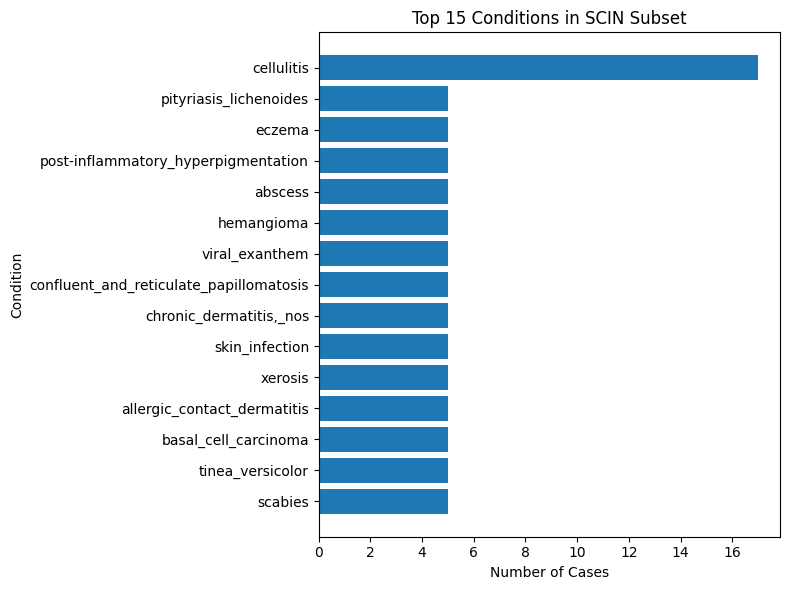

In [17]:
import matplotlib.pyplot as plt

# Top 15 conditions
top15 = scin_balanced["condition_clean"].value_counts().head(15)
plt.figure(figsize=(8,6))
plt.barh(top15.index[::-1], top15.values[::-1])
plt.title("Top 15 Conditions in SCIN Subset")
plt.xlabel("Number of Cases"); plt.ylabel("Condition")
plt.tight_layout(); plt.savefig("condition_distribution_top15.png", dpi=300); plt.show()

/tmp/ipython-input-3899091016.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=scin_balanced, x="triage_class", palette="Set2",


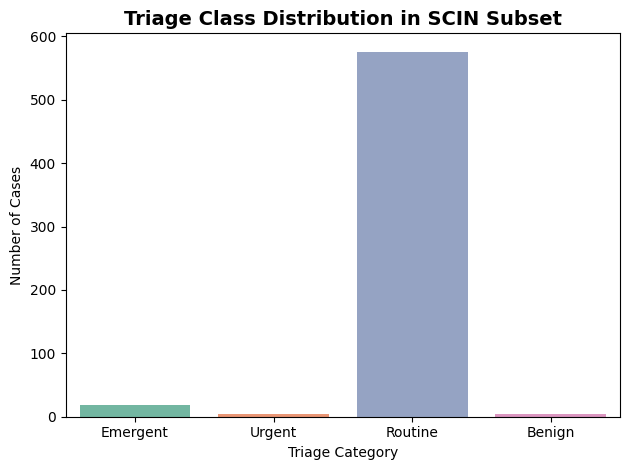

In [18]:
import seaborn as sns

sns.countplot(data=scin_balanced, x="triage_class", palette="Set2",
              order=["Emergent","Urgent","Routine","Benign"])
plt.title("Triage Class Distribution in SCIN Subset", fontsize=14, weight="bold")
plt.xlabel("Triage Category"); plt.ylabel("Number of Cases")
plt.tight_layout()
plt.savefig("triage_class_distribution.png", dpi=300)
plt.show()

In [19]:
# Test to see if the "image_url" works with gemini
!pip install google-generativeai pandas --upgrade
from google.colab import userdata
import google.generativeai as genai
import os, pandas as pd
from PIL import Image
import requests
import io

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# load your subset CSV
df = pd.read_csv("scin_subset_balanced_labeled.csv")

# pick one row to test
row = df.sample(1, random_state=7).iloc[0]
img_url = row["image_url"]

# download image bytes and open with PIL
resp = requests.get(img_url, timeout=20)
resp.raise_for_status()
img = Image.open(io.BytesIO(resp.content)).convert("RGB")

# call Gemini with image only
model = genai.GenerativeModel("gemini-2.5-flash")
prompt = "Briefly describe notable skin findings in this image for triage (no diagnosis)."

result = model.generate_content([prompt, img])
print("Image URL:", img_url)
print("Model output:\n", result.text)

# Multi-image case (SCIN often has up to 3 photos per case)
# Build up to 3 URLs for a case, send them all at once
parts = [prompt]
for col in ["image_1_path", "image_2_path", "image_3_path"]:
    if col in df.columns and pd.notna(row.get(col)):
        url = "https://storage.googleapis.com/dx-scin-public-data/" + row[col]
        r = requests.get(url, timeout=20); r.raise_for_status()
        parts.append(Image.open(io.BytesIO(r.content)).convert("RGB"))

result = model.generate_content(parts)
print(result.text)

Image URL: https://storage.googleapis.com/dx-scin-public-data/dataset/images/-3365177614917497298.png
Model output:
 The image displays multiple erythematous (reddened), raised, and irregularly shaped skin lesions on a hairy extremity. Many of these lesions appear linear or serpiginous, with some coalescing into larger patches. The surrounding skin also shows numerous small, light brown macules.
The image displays multiple irregular, erythematous (red), raised, and edematous lesions on the skin of an extremity. These lesions vary in size and shape, with some appearing as blotchy patches and others exhibiting linear or serpiginous (wavy) configurations, consistent with wheals or welts. No obvious blistering, crusting, or significant scaling is observed. The surrounding skin is fair-toned with prominent hair follicles and scattered freckles.


In [20]:
N = 5
subset = df.sample(N, random_state=11)

model = genai.GenerativeModel("gemini-2.5-flash")
prompt = "Summarize visible findings for triage (one sentence)."

for i, r in subset.iterrows():
    try:
        url = r["image_url"]
        b = requests.get(url, timeout=20); b.raise_for_status()
        img = Image.open(io.BytesIO(b.content)).convert("RGB")
        out = model.generate_content([prompt, img])
        print(f"\n[{r.get('case_id', i)}] {url}\n-> {out.text}")
    except Exception as e:
        print(f"\n[{r.get('case_id', i)}] error: {e}")


[-6195806766943101605] https://storage.googleapis.com/dx-scin-public-data/dataset/images/6540654300986766423.png
-> The patient presents with numerous small, red-purple, punctate spots scattered across the forearm, consistent with a petechial rash.

[29603347008403047] https://storage.googleapis.com/dx-scin-public-data/dataset/images/-372835175855794061.png
-> A widespread rash consisting of multiple scattered red lesions is visible on the patient's torso.

[-3116603665450719306] https://storage.googleapis.com/dx-scin-public-data/dataset/images/-446206036030978724.png
-> A prominent, inflamed, erythematous plaque with some scaling is visible in the axilla.

[-2727997541216656153] https://storage.googleapis.com/dx-scin-public-data/dataset/images/-2339569838872037676.png
-> Visible findings include an erythematous, raised, serpiginous-patterned skin eruption with a papulovesicular appearance on the upper leg.

[-1022162013984621110] https://storage.googleapis.com/dx-scin-public-data/dat

In [21]:
def show_img_and_gemini(row, prompt="Describe findings for triage (no diagnosis)."):
    # Download bytes
    resp = requests.get(row["image_url"], timeout=20); resp.raise_for_status()
    img = Image.open(io.BytesIO(resp.content)).convert("RGB")

    # Gemini call
    result = model.generate_content([prompt, img])
    text = (result.text or "").strip()

    # Side-by-side preview
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios":[1.2, 1]})
    ax[0].imshow(img); ax[0].axis("off")
    title_left = f"case_id: {row.get('case_id','?')}\ncondition: {row.get('condition_clean','?')}\nFST: {row.get('fitzpatrick_skin_type','?')}"
    ax[0].set_title(title_left, fontsize=10, loc="left")

    ax[1].axis("off")
    #ax[1].text(0, 1, "Gemini output:", fontsize=12, weight="bold", va="top")
    ax[1].text(0, 0.95, text, fontsize=11, va="top", wrap=True, transform=ax[1].transAxes)
    plt.tight_layout()
    plt.show()

    print("Image URL:", row["image_url"])
    print("Gemini output:\n", text)


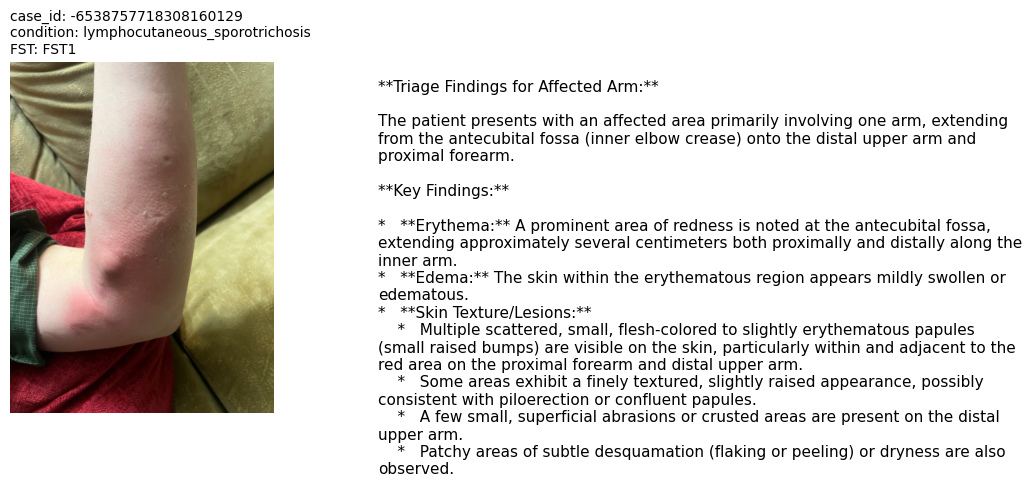

Image URL: https://storage.googleapis.com/dx-scin-public-data/dataset/images/-5108397352863519360.png
Gemini output:
 **Triage Findings for Affected Arm:**

The patient presents with an affected area primarily involving one arm, extending from the antecubital fossa (inner elbow crease) onto the distal upper arm and proximal forearm.

**Key Findings:**

*   **Erythema:** A prominent area of redness is noted at the antecubital fossa, extending approximately several centimeters both proximally and distally along the inner arm.
*   **Edema:** The skin within the erythematous region appears mildly swollen or edematous.
*   **Skin Texture/Lesions:**
    *   Multiple scattered, small, flesh-colored to slightly erythematous papules (small raised bumps) are visible on the skin, particularly within and adjacent to the red area on the proximal forearm and distal upper arm.
    *   Some areas exhibit a finely textured, slightly raised appearance, possibly consistent with piloerection or confluent 

In [22]:
show_img_and_gemini(df.sample(1, random_state=9).iloc[0])

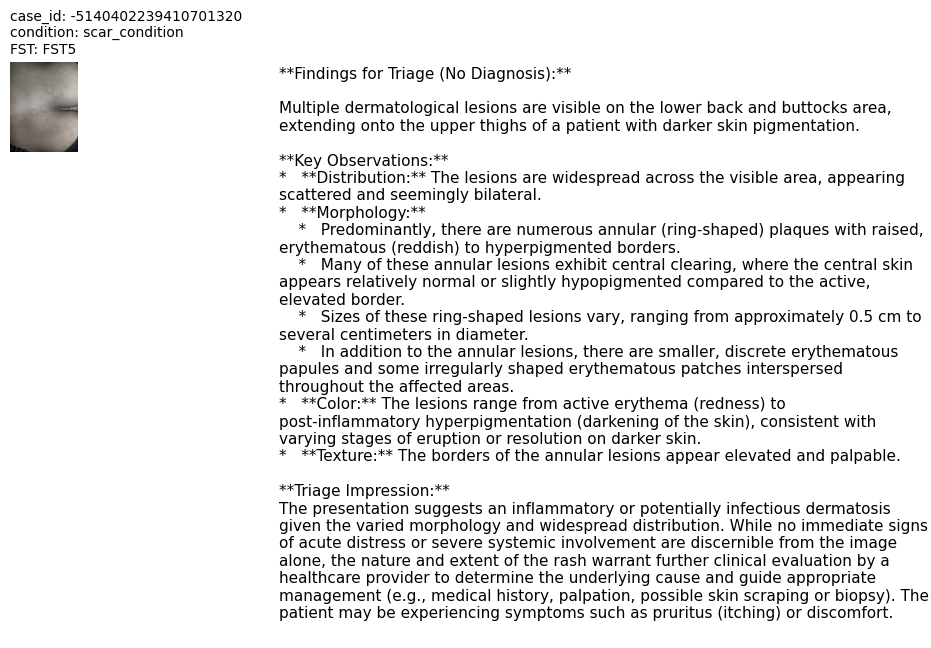

Image URL: https://storage.googleapis.com/dx-scin-public-data/dataset/images/-4772826539396708402.png
Gemini output:
 **Findings for Triage (No Diagnosis):**

Multiple dermatological lesions are visible on the lower back and buttocks area, extending onto the upper thighs of a patient with darker skin pigmentation.

**Key Observations:**
*   **Distribution:** The lesions are widespread across the visible area, appearing scattered and seemingly bilateral.
*   **Morphology:**
    *   Predominantly, there are numerous annular (ring-shaped) plaques with raised, erythematous (reddish) to hyperpigmented borders.
    *   Many of these annular lesions exhibit central clearing, where the central skin appears relatively normal or slightly hypopigmented compared to the active, elevated border.
    *   Sizes of these ring-shaped lesions vary, ranging from approximately 0.5 cm to several centimeters in diameter.
    *   In addition to the annular lesions, there are smaller, discrete erythematous pap

In [24]:
show_img_and_gemini(df.sample(1, random_state=16).iloc[0])

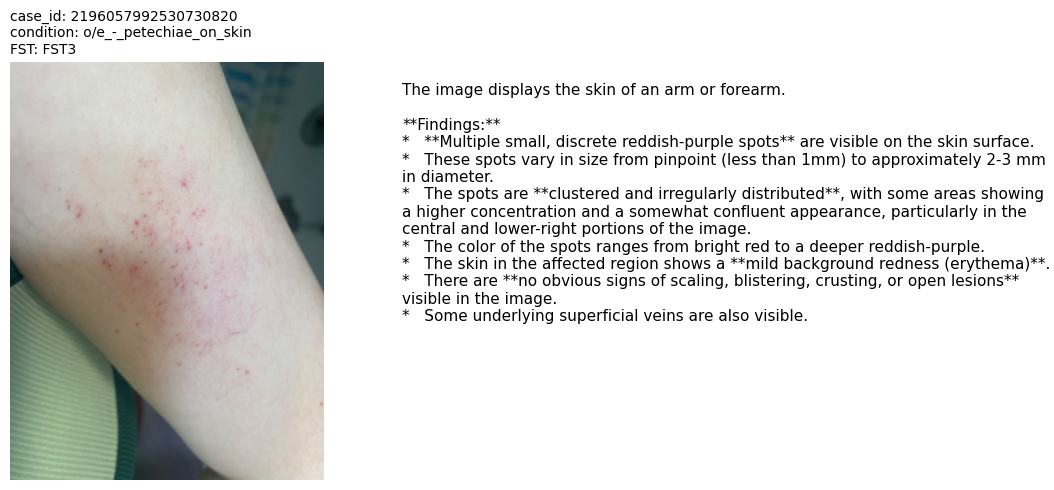

Image URL: https://storage.googleapis.com/dx-scin-public-data/dataset/images/-6251898218287982790.png
Gemini output:
 The image displays the skin of an arm or forearm.

**Findings:**
*   **Multiple small, discrete reddish-purple spots** are visible on the skin surface.
*   These spots vary in size from pinpoint (less than 1mm) to approximately 2-3 mm in diameter.
*   The spots are **clustered and irregularly distributed**, with some areas showing a higher concentration and a somewhat confluent appearance, particularly in the central and lower-right portions of the image.
*   The color of the spots ranges from bright red to a deeper reddish-purple.
*   The skin in the affected region shows a **mild background redness (erythema)**.
*   There are **no obvious signs of scaling, blistering, crusting, or open lesions** visible in the image.
*   Some underlying superficial veins are also visible.


In [25]:
show_img_and_gemini(df.sample(1, random_state=10).iloc[0])

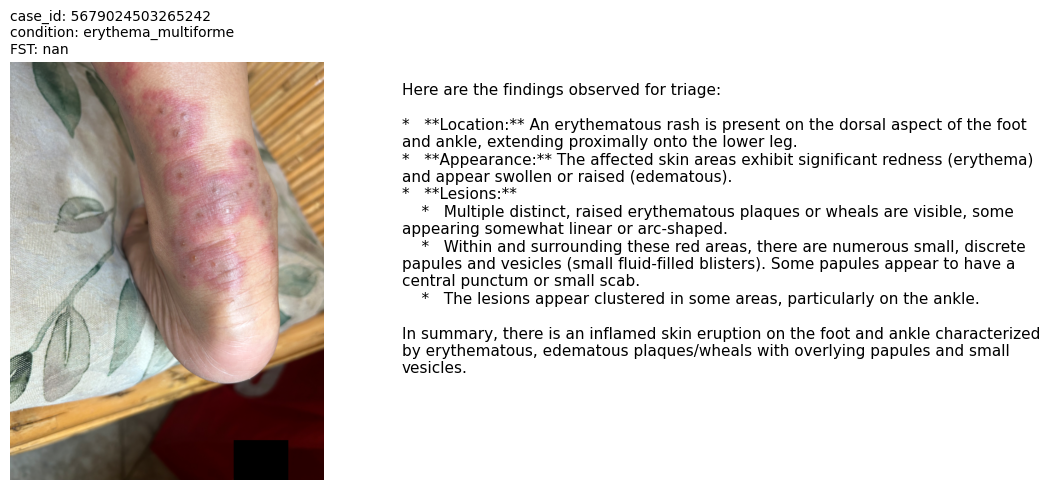

Image URL: https://storage.googleapis.com/dx-scin-public-data/dataset/images/7850315044977794844.png
Gemini output:
 Here are the findings observed for triage:

*   **Location:** An erythematous rash is present on the dorsal aspect of the foot and ankle, extending proximally onto the lower leg.
*   **Appearance:** The affected skin areas exhibit significant redness (erythema) and appear swollen or raised (edematous).
*   **Lesions:**
    *   Multiple distinct, raised erythematous plaques or wheals are visible, some appearing somewhat linear or arc-shaped.
    *   Within and surrounding these red areas, there are numerous small, discrete papules and vesicles (small fluid-filled blisters). Some papules appear to have a central punctum or small scab.
    *   The lesions appear clustered in some areas, particularly on the ankle.

In summary, there is an inflamed skin eruption on the foot and ankle characterized by erythematous, edematous plaques/wheals with overlying papules and small vesi

In [27]:
show_img_and_gemini(df.sample(1, random_state=49).iloc[0])

In [23]:
# agreement between condition_clean and dermatologist labels
def check_agreement(row):
    clean_condition = row["condition_clean"]
    derm_labels_str = row["dermatologist_skin_condition_on_label_name"]

    if pd.isna(clean_condition) or pd.isna(derm_labels_str):
        return False

    try:
        derm_labels = ast.literal_eval(derm_labels_str)
        derm_labels_normalized = [label.lower().replace(" ", "_") for label in derm_labels]
        return clean_condition in derm_labels_normalized
    except Exception:
        return False

scin_balanced["agreement"] = scin_balanced.apply(check_agreement, axis=1)

reliability_score = scin_balanced["agreement"].mean() * 100

print(f"Reliability Score (Agreement between condition_clean and dermatologist labels): {reliability_score:.2f}%")


Reliability Score (Agreement between condition_clean and dermatologist labels): 99.17%
